# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project aims to apply Natural Language Processing (NLP) techniques to analyze the content of comments that are publicly available on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149) for this docket. For technical reasons (see the [Data_Prep notebook](./Data_Prep.ipynb)), the dataset only includes ~8K comments, which are the ones typed directly onto the site. The dataset excludes another ~3K comments submitted in an attachment form (most of which were PDFs).

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [13]:
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import decomposition

In [2]:
full_df = pd.read_pickle('./Data/full_df.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...


In [3]:
comments = full_df['Comment']

comments.head()

0    I write to express my opposition to the Enviro...
1    I write to express my opposition to the Enviro...
2    Please abandon this proposed rollback of the 2...
3    My husband and I have two wonderful daughters,...
4    Please do not change the definitions within th...
Name: Comment, dtype: object

In [14]:
# Split comments into train and test sets
train, test = train_test_split(comments,
                               test_size=0.25,
                               random_state=42)

print(train.shape, test.shape)

(6140,) (2047,)


## Topic Analysis

In [40]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic-by-vocabulary orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

### Singular Value Decomposition Analysis

In [30]:
# Create matrix with word counts by comment
count_vec = CountVectorizer(stop_words='english')
vocab_vecs = count_vec.fit_transform(train).todense()
print(vocab_vecs.shape)

# Create array of vocabulary terms
vocab = np.array(count_vec.get_feature_names())

(6140, 19413)


In [33]:
print(vocab[2000:2020])

['authentic' 'author' 'authoring' 'authoritarian' 'authorities'
 'authority' 'authorization' 'authorize' 'authorized' 'authorizes'
 'authorizing' 'authors' 'autism' 'auto' 'autocrat' 'autofilled'
 'autogenic' 'autoimmune' 'automated' 'automatic']


In [41]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(vocab_vecs, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(6140, 6140) (6140,) (6140, 19413)


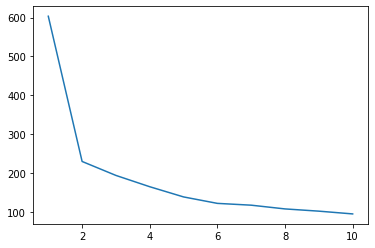

In [45]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);

In [47]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['winthrop rosamond torrance faillacetarrytown lunatic jaegerssaint gratefully annilyn',
 'water clean waterways families act proposal drinking gut',
 'epa states waters definition farmers support united land',
 'waters streams waterways act proposal states tributaries definition',
 'waters water quality states united protections park wetlands',
 'waterways rule polluters dirty clean protections communities waters',
 'waters clean act protection dirty 2015 case environmental',
 'proposed protections park quality parks case support national',
 'water definition wotus drinking epa bodies protection cwa',
 'epa corps wetlands park proposal protections streams parks']

### NMF

## Temp test data

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [34]:
categories = ["alt.atheism", "sci.space"]
remove = ("headers", "footers", "quotes")

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train',
                          categories=categories,
                          remove=remove)

print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'sci.space']
1073 documents
2 categories



In [35]:
data.data[:3]

[': \n: >> Please enlighten me.  How is omnipotence contradictory?\n: \n: >By definition, all that can occur in the universe is governed by the rules\n: >of nature. Thus god cannot break them. Anything that god does must be allowed\n: >in the rules somewhere. Therefore, omnipotence CANNOT exist! It contradicts\n: >the rules of nature.\n: \n: Obviously, an omnipotent god can change the rules.\n\nWhen you say, "By definition", what exactly is being defined;\ncertainly not omnipotence. You seem to be saying that the "rules of\nnature" are pre-existant somehow, that they not only define nature but\nactually cause it. If that\'s what you mean I\'d like to hear your\nfurther thoughts on the question.',
 "In <19APR199320262420@kelvin.jpl.nasa.gov> baalke@kelvin.jpl.nasa.gov \n\nSorry I think I missed a bit of info on this Transition Experiment. What is it?\n\nWill this mean a loss of data or will the Magellan transmit data later on ??\n\nBTW: When will NASA cut off the connection with Magella

In [36]:
t_count_vec = CountVectorizer(stop_words='english')
t_vocab_vecs = t_count_vec.fit_transform(data.data).todense()

t_vocab_vecs.shape

(1073, 17919)

In [37]:
t_vocab = np.array(t_count_vec.get_feature_names())
print(t_vocab.shape)

(17919,)


In [38]:
t_U, t_s, t_Vh = linalg.svd(t_vocab_vecs, full_matrices=False)
print(t_U.shape, t_s.shape, t_Vh.shape)

(1073, 1073) (1073,) (1073, 17919)


In [39]:
show_topics(t_Vh[:10], t_vocab)

['propagandist sandvik surname galacticentric warned kindergarten reconcile surreal',
 'space launch satellite nasa commercial market satellites data',
 'god atheists atheism religious believe argument religion true',
 'nasa space lunar available mars probe moon edu',
 'atheists religious atheism god religion believe belief atheist',
 'nasa space available ftp edu data gov anonymous',
 'larson theory universe physical unified star motion physicist',
 'space shuttle society telescope news international national aerospace',
 'telescope word national observatory satellite infrared center prefix',
 'god response posting subject typical information einstein bush']